In [1]:
# to reduce the deprecation warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
#check we have a GPU available
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3403690616765883247
 xla_global_id: -1]

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from astroML.utils import split_samples
%matplotlib inline

In [4]:
np.set_printoptions(precision=2)

def normalize_image(image):
    '''Rescale the constrast in an image based on the noise (used for displays and the CNN)'''
    sigmaG_coeff =  0.7413
    image = image.reshape(21,21)
    
    per25,per50,per75 = np.percentile(image,[25,50,75])
    sigmaG = sigmaG_coeff * (per75 - per25)
    # sigma clip image, remove background, and normalize to unity
    image[image<(per50-2*sigmaG)] = per50-2*sigmaG
    image -= np.min(image)
    image /= np.sum(image)
    
    return image
    
def plot_image_array(images, nrows=2, ncols=5, figsize=[8,4], nx=21, ny=21, title='', subtitle=False, 
                     class_true=None, classes=None):
    '''Plot an array of images'''
    fig, ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=figsize)
    fig.subplots_adjust(hspace=0, left=0.07, right=0.95, wspace=0.05, bottom=0.15)
    for indx in np.arange(nrows*ncols):
        i = int(indx/ncols)
        j = indx%ncols
        if (i == 0):
            ax[i][j].xaxis.set_major_formatter(plt.NullFormatter())
        if (j != 0):
            ax[i][j].yaxis.set_major_formatter(plt.NullFormatter())

        ax[i][j].imshow(images[indx].reshape(nx,ny), cmap='gray')
        if (subtitle == True):
            ax[i][j].set_title('True Class: %i, Predicted Class: %i\n  Prob Class 1 %e ' % 
              (np.argmax(class_true[indx]), np.argmax(classes[indx]), classes[indx,1]))

    fig.suptitle(title)
    ax[0][0].set_ylabel('$y$')
    ax[nrows-1][int(ncols/2)].set_xlabel('$x$')            
    
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, 
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    From scikit-learn: plots a confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    #fixes "squishing of plot"
    plt.ylim([1.5, -.5]) 
    
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()

def plot_model_history(history):
    '''Plot the training and validation history for a TensorFlow network'''

    # Extract loss and accuracy
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(10,5))
    ax[0].plot(np.arange(n_epochs), loss, label='Training Loss')
    ax[0].plot(np.arange(n_epochs), val_loss, label='Validation Loss')
    ax[0].set_title('Loss Curves')
    ax[0].legend()
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')

    ax[1].plot(np.arange(n_epochs), acc, label='Training Accuracy')
    ax[1].plot(np.arange(n_epochs), val_acc, label='Validation Accuracy')
    ax[1].set_title('Accuracy Curves')
    ax[1].legend()
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')

In [5]:
# Brute force direct downloads source and noise images to circumvent size limitations 
# for google drive internal virus scan. Download may take some time.

import os
import requests

files = {'sources': (os.path.join('data', 'stamps_noise.npy'), '1UT2BCf-IDUEpvTmcU4bq6nDcY3Ayw5vJ'),
         'noise': (os.path.join('data', 'stamps_sources.npy'), '1cZaMCA0z_nPX6GB_meLGouwOidEROcwc')}

for name, file_id in files.values():
    if not os.path.exists(name):
        print(f"Downloading file {name}.")
        
        os.makedirs(os.path.dirname(name), exist_ok=True)
        url = f"https://docs.google.com/uc?export=download&id={file_id}&confirm=t"
        response = requests.post(url)
        with open(name, 'wb') as file:
            file.write(response.content) 
    print(f"File {name} is downloaded")
            
sources = np.load(files['sources'][0])
noise = np.load(files['noise'][0])

File data\stamps_noise.npy is downloaded
File data\stamps_sources.npy is downloaded


In [6]:
# normalizing images

point_source_stamps = []
for image in sources:
    point_source_stamps.append(normalize_image(image))

no_point_source_stamps = []
for image in noise:
    no_point_source_stamps.append(normalize_image(image))

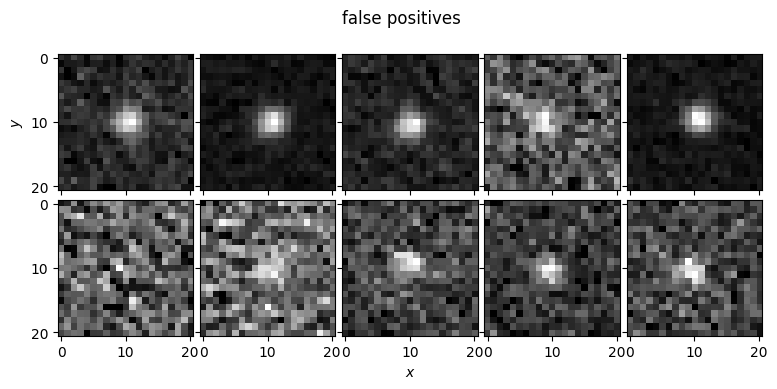

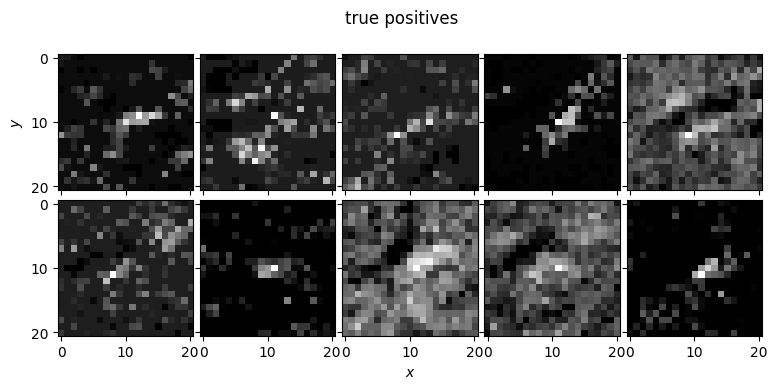

In [7]:
# plot sample of images
plot_image_array(no_point_source_stamps, title='false positives')
plot_image_array(point_source_stamps, title='true positives')

In [8]:
from tensorflow.keras.utils import to_categorical
def reshape_arrays(data, labels):
    '''reshape arrays for Keras'''
    data = data.reshape(-1,21, 21, 1) 
    labels = to_categorical(labels)
    return data,labels

# combine the false positives and true positives
input_stamps = np.vstack([no_point_source_stamps, point_source_stamps])
stamp_class = np.zeros(len(no_point_source_stamps) + len(point_source_stamps))
stamp_class[len(no_point_source_stamps):] = 1 # 0 for noise, 1 for a star

# split the samples into training, validation and test data sets
(data_train, data_val, data_test), (class_train, class_val, class_test) = split_samples(input_stamps, stamp_class, 
                                                                                        [0.7,0.1,0.2])
data_train, class_train = reshape_arrays(data_train, class_train)
data_val, class_val = reshape_arrays(data_val, class_val)
data_test, class_test = reshape_arrays(data_test, class_test)

print ('Number of samples in the training ({}); test ({}); and validation ({}) data sets'.format(data_train.shape[0], 
                                                                                    data_test.shape[0],
                                                                                   data_val.shape[0]))

Number of samples in the training (76666); test (21905); and validation (10952) data sets


In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Activation
from tensorflow.keras.utils import to_categorical

def simple(input_shape=(21, 21, 1), n_classes: int = 2):

    model = tf.keras.models.Sequential(name='simple')

    # input: 21x21 images with 1 channel -> (21, 21, 1) tensors.
    model.add(tf.keras.layers.Dense(30, input_shape=input_shape, activation='relu', name='fc_1'))
        
    model.add(tf.keras.layers.Dense(30, activation='relu', name='fc_2'))

    # output layer
    model.add(tf.keras.layers.Flatten())
    activation = 'sigmoid' if n_classes == 1 else 'softmax'
    model.add(tf.keras.layers.Dense(n_classes, activation=activation, name='fc_out'))

    return model

In [10]:
#output the structure of the model
simple_model = simple()
simple_model.summary()

Model: "simple"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc_1 (Dense)                (None, 21, 21, 30)        60        
                                                                 
 fc_2 (Dense)                (None, 21, 21, 30)        930       
                                                                 
 flatten (Flatten)           (None, 13230)             0         
                                                                 
 fc_out (Dense)              (None, 2)                 26462     
                                                                 
Total params: 27452 (107.23 KB)
Trainable params: 27452 (107.23 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
n_epochs=1
batch_size=1
simple_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
simple_model_history = simple_model.fit(data_train, class_train, epochs=n_epochs, batch_size=batch_size,  verbose=1, 
                                        validation_data=(data_val, class_val), shuffle=True)

76666/76666 [==============================] - 88s 1ms/step - loss: 0.6319 - accuracy: 0.6204 - val_loss: 0.6904 - val_accuracy: 0.5412


In [13]:
n_epochs=20
batch_size=simple_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
simple_model_history = simple_model.fit(data_train, class_train, epochs=n_epochs, batch_size=batch_size,  verbose=1, 
                                        validation_data=(data_val, class_val), shuffle=True)

Epoch 1/20
2396/2396 [==============================] - 18s 7ms/step - loss: 0.6884 - accuracy: 0.5490 - val_loss: 0.6901 - val_accuracy: 0.5412
Epoch 2/20
2396/2396 [==============================] - 18s 7ms/step - loss: 0.6884 - accuracy: 0.5490 - val_loss: 0.6898 - val_accuracy: 0.5412
Epoch 3/20
2396/2396 [==============================] - 18s 8ms/step - loss: 0.6884 - accuracy: 0.5490 - val_loss: 0.6899 - val_accuracy: 0.5412
Epoch 4/20
2396/2396 [==============================] - 22s 9ms/step - loss: 0.6868 - accuracy: 0.5490 - val_loss: 0.6848 - val_accuracy: 0.5412
Epoch 5/20
2396/2396 [==============================] - 18s 8ms/step - loss: 0.6784 - accuracy: 0.5497 - val_loss: 0.6757 - val_accuracy: 0.5442
Epoch 6/20
2396/2396 [==============================] - 21s 9ms/step - loss: 0.5338 - accuracy: 0.7776 - val_loss: 0.4230 - val_accuracy: 0.8868
Epoch 7/20
2396/2396 [==============================] - 22s 9ms/step - loss: 0.3890 - accuracy: 0.8891 - val_loss: 0.3607 - val_ac

### Performance of the network

In [14]:
# use the network to predict class values
classes = simple_model.predict(data_test)
print (classes)

685/685 [==============================] - 3s 4ms/step
[[1.59e-01 8.41e-01]
 [5.08e-01 4.92e-01]
 [6.05e-02 9.39e-01]
 ...
 [3.02e-01 6.98e-01]
 [8.98e-01 1.02e-01]
 [1.00e+00 8.87e-09]]


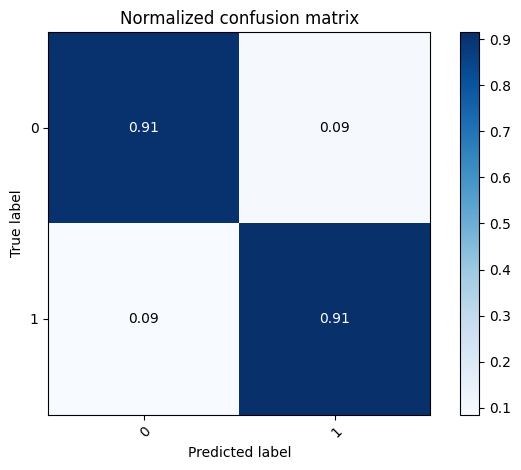

In [15]:
# plot the confusion matrix
plot_confusion_matrix(np.argmax(class_test,axis=1), np.argmax(classes,axis=1), normalize=True,
                      title='Normalized confusion matrix')

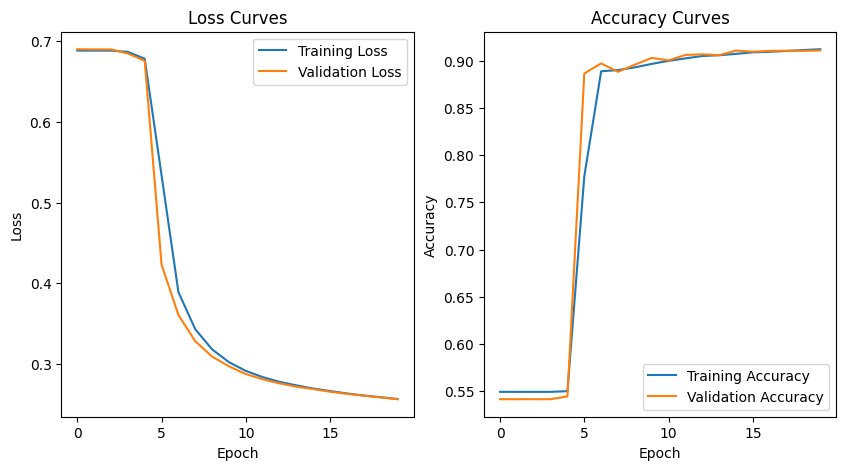

In [16]:
# plot the training history of the network
plot_model_history(simple_model_history)

In [18]:
def simpleBN(input_shape=(21, 21, 1), n_classes: int = 2):

    model = tf.keras.models.Sequential(name='simple')

    # input: 21x21 images with 1 channel -> (21, 21, 1) tensors.
    model.add(tf.keras.layers.Dense(30, input_shape=input_shape, activation='relu', name='fc_1'))
        
    model.add(tf.keras.layers.Dense(30, activation='relu', name='fc_2'))

    # output layer
    model.add(tf.keras.layers.Flatten())
    activation = 'sigmoid' if n_classes == 1 else 'softmax'
    model.add(tf.keras.layers.Dense(n_classes, activation=activation, name='fc_out'))

    return model

In [19]:
n_epochs=20
simple_model = simpleBN()
simple_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
simple_model_history = simple_model.fit(data_train, class_train, epochs=n_epochs, batch_size=256, verbose=1, 
                                        validation_data=(data_val, class_val), shuffle=True)
classes = simple_model.predict(data_test)

Epoch 1/20
300/300 [==============================] - 21s 67ms/step - loss: 0.6889 - accuracy: 0.5485 - val_loss: 0.6902 - val_accuracy: 0.5412
Epoch 2/20
300/300 [==============================] - 16s 54ms/step - loss: 0.6883 - accuracy: 0.5489 - val_loss: 0.6897 - val_accuracy: 0.5412
Epoch 3/20
300/300 [==============================] - 15s 51ms/step - loss: 0.6883 - accuracy: 0.5489 - val_loss: 0.6897 - val_accuracy: 0.5412
Epoch 4/20
300/300 [==============================] - 15s 51ms/step - loss: 0.6883 - accuracy: 0.5489 - val_loss: 0.6898 - val_accuracy: 0.5412
Epoch 5/20
300/300 [==============================] - 15s 51ms/step - loss: 0.6883 - accuracy: 0.5489 - val_loss: 0.6898 - val_accuracy: 0.5412
Epoch 6/20
300/300 [==============================] - 15s 51ms/step - loss: 0.6882 - accuracy: 0.5489 - val_loss: 0.6896 - val_accuracy: 0.5412
Epoch 7/20
300/300 [==============================] - 15s 51ms/step - loss: 0.6882 - accuracy: 0.5489 - val_loss: 0.6898 - val_accuracy:

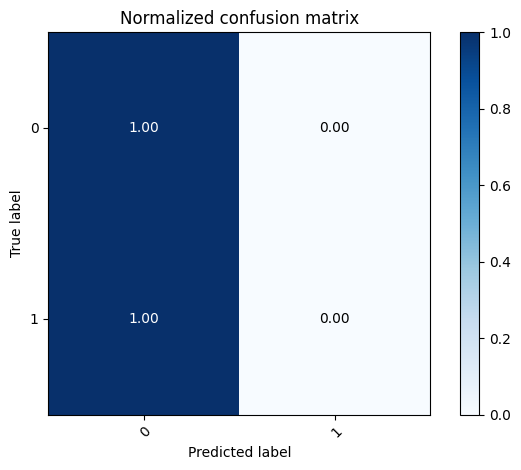

In [20]:
# Plot normalized confusion matrix
plot_confusion_matrix(np.argmax(class_test,axis=1), np.argmax(classes,axis=1), normalize=True,
                      title='Normalized confusion matrix')

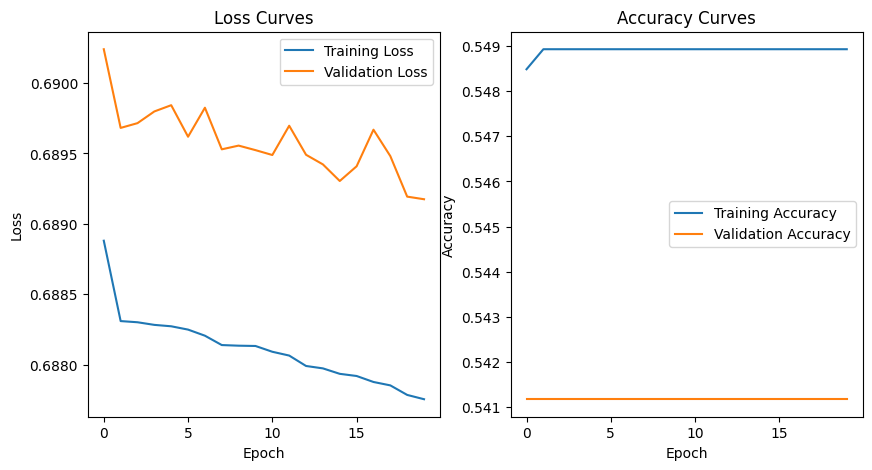

In [21]:
plot_model_history(simple_model_history)

In [22]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten
from tensorflow.keras.utils import to_categorical

def vgg6(input_shape=(21, 21, 1), n_classes: int = 2):
    """
        VGG6
    :param input_shape:
    :param n_classes:
    :return:
    """

    model = tf.keras.models.Sequential(name='VGG6')
    # input: 21x21 images with 1 channel -> (21, 21, 1) tensors.
    # this applies 16 convolution filters of size 3x3 each.
    model.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape, name='conv1'))
    model.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu', name='conv2'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', name='conv3'))
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', name='conv4'))
    model.add(tf.keras.layers.BatchNormalization(axis = 3, name = 'bn_2'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(4, 4)))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(256, activation='relu', name='fc_1'))
    model.add(tf.keras.layers.Dropout(0.5))
    # output layer
    activation = 'sigmoid' if n_classes == 1 else 'softmax'
    model.add(tf.keras.layers.Dense(n_classes, activation=activation, name='fc_out'))

    return model

In [23]:
vgg_model = vgg6()
vgg_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
n_epochs=15
vgg_model.summary()
vgg_model_history = vgg_model.fit(data_train, class_train, epochs=n_epochs, batch_size=1024, verbose=2, 
                                  validation_data=(data_val, class_val), shuffle=True)
classes = vgg_model.predict(data_test)

Model: "VGG6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 19, 19, 16)        160       
                                                                 
 conv2 (Conv2D)              (None, 17, 17, 16)        2320      
                                                                 
 max_pooling2d (MaxPooling2  (None, 8, 8, 16)          0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 8, 8, 16)          0         
                                                                 
 conv3 (Conv2D)              (None, 6, 6, 32)          4640      
                                                                 
 conv4 (Conv2D)              (None, 4, 4, 32)          9248      
                                                              

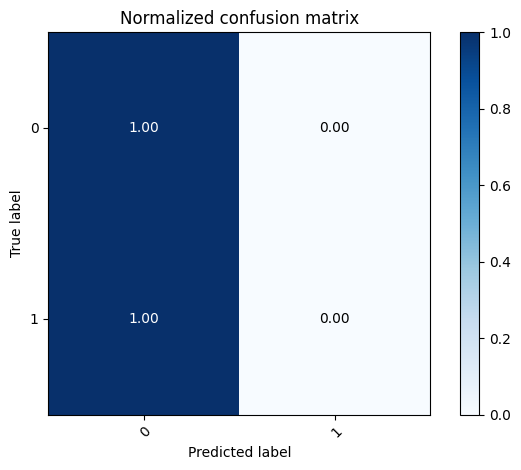

In [24]:
# plot the confusion matrix
plot_confusion_matrix(np.argmax(class_test,axis=1), np.argmax(classes,axis=1), normalize=True,
                      title='Normalized confusion matrix')

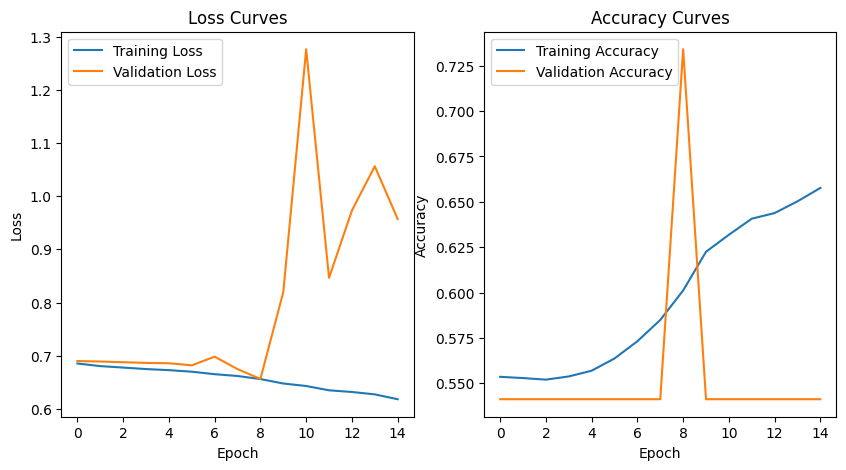

In [25]:
# plot the training history
plot_model_history(vgg_model_history)

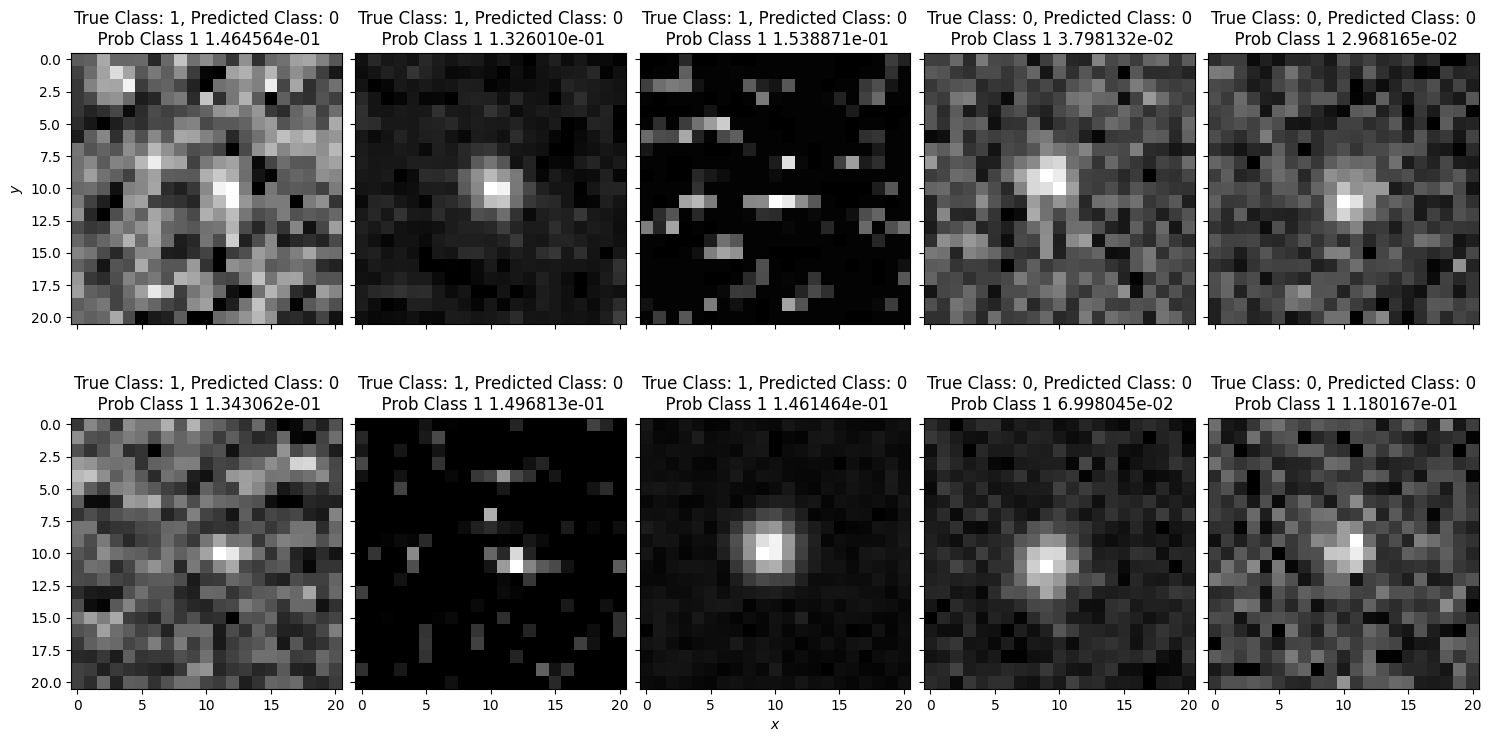

In [26]:
# plot example classifications
plot_image_array(data_val, figsize=[16,10], subtitle=True, classes=classes, class_true=class_test)

10/10 [==============================] - 0s 5ms/step


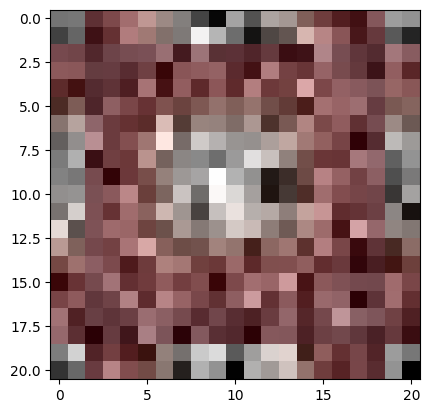

In [28]:
model = vgg_model
image_number = 11

kernel_size=5
input_stamp = data_test[image_number].reshape(21,21)
i = 0
j=0
heatmap = []
keras_stamps = []
for j in range(22-kernel_size):
    for i in range(22-kernel_size):
        img = np.copy(input_stamp)
        img[i:i+kernel_size,j:j+kernel_size] = 0
        img = normalize_image(img)
        keras_stamps.append(img)
keras_stamps = np.array(keras_stamps).reshape([-1,21,21,1])
probs = 1. - model.predict(keras_stamps)
heatmap = probs[:,1].reshape(22-kernel_size,22-kernel_size)

def transparent_cmap(cmap, N=255):
    "Copy colormap and set alpha values"
    mycmap = cmap
    mycmap._init()
    mycmap._lut[:,-1] = np.linspace(0, 0.8, N+4)
    return mycmap

# pad heatmap to same size as original image
heatmap = np.pad(heatmap, pad_width=int(kernel_size/2), mode='minimum')

# use the base cmap to create transparent overlay
mycmap = transparent_cmap(plt.cm.Reds)
fig, ax = plt.subplots(nrows=1,ncols=1)
ax.imshow(data_test[image_number].reshape(21,21), cmap='gray')
ax.imshow(np.array(heatmap), alpha=0.5, cmap=mycmap)

In [29]:
# Based on https://github.com/priya-dwivedi/Deep-Learning/blob/master/resnet_keras/Residual_Networks_yourself.ipynb
import tensorflow as tf
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K
K.set_image_data_format('channels_last')
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 3
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)


    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)


    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1',
                        kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

def ResNet50(input_shape=(21, 21, 1), classes=2):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    #X = AveragePooling2D((2,2), name="avg_pool")(X)

    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [30]:
resnet50_model = ResNet50()
resnet50_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
n_epochs=5
resnet_model_history = resnet50_model.fit(data_train, class_train, epochs=n_epochs, batch_size=256, verbose=1, 
                                          validation_data=(data_val, class_val), shuffle=True)

Epoch 1/5
300/300 [==============================] - 2161s 7s/step - loss: 0.1369 - accuracy: 0.9601 - val_loss: 1.9115 - val_accuracy: 0.4588
Epoch 2/5
300/300 [==============================] - 3151s 11s/step - loss: 0.0344 - accuracy: 0.9872 - val_loss: 0.4942 - val_accuracy: 0.7866
Epoch 3/5
300/300 [==============================] - 3091s 10s/step - loss: 0.0267 - accuracy: 0.9899 - val_loss: 0.0536 - val_accuracy: 0.9795
Epoch 4/5
300/300 [==============================] - 3199s 11s/step - loss: 0.0208 - accuracy: 0.9922 - val_loss: 0.0419 - val_accuracy: 0.9861
Epoch 5/5
300/300 [==============================] - 2164s 7s/step - loss: 0.0172 - accuracy: 0.9933 - val_loss: 0.0815 - val_accuracy: 0.9706


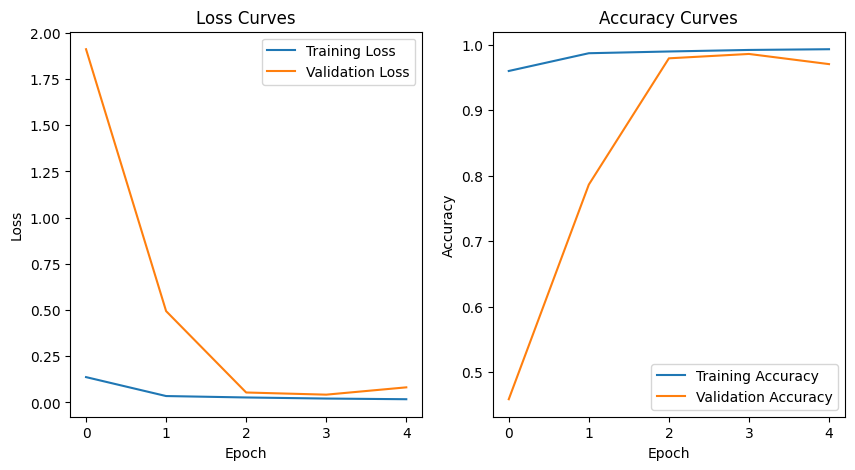

In [31]:
plot_model_history(resnet_model_history)